<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

# HOOPS AI: EXPERIMENTAL - Flow Trainer

## Purpose
`FlowTrainer` orchestrates the complete training workflow for Flow Models, handling:

- Dataset loading and splitting (train/validation/test)
- Model initialization and checkpointing
- Training loop with PyTorch Lightning
- Metric logging and visualization
- Data quality validation (purify method)

## Core Components:

* flowmodel (FlowModel): Initialized FlowModel implementation
* datasetLoader (DatasetLoader): Dataset with train/val/test splits

## Training Configuration:

* batch_size (int): Samples per training batch (default: 64)
* num_workers (int): DataLoader worker processes (default: 0)
* experiment_name (str): Name for logging and checkpoints
* accelerator (str): 'cpu', 'gpu', or 'tpu' (default: 'cpu')
* devices (int or 'auto'): Number of devices to use (default: 'auto')
* gradient_clip_val (float): Gradient clipping threshold (default: 1.0)
* max_epochs (int): Maximum training epochs (default: 100)
* learning_rate (float): Initial learning rate (default: 0.002)
* result_dir (str): Output directory for results

```python

class FlowTrainer:
    def __init__(
        self,
        flowmodel: FlowModel = None,        
        datasetLoader: DatasetLoader = None,
        ...
    ):
        
    def train(self) -> str
    def test(self, checkpoint_path: str = None) -> Dict[str, float]:
    def purify(self) -> List[int]:
```

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)

ℹ️ Using TEST LICENSE (expires February 8th, 2026 - 12 days remaining)
   For production use, obtain your own license from Tech Soft 3D
HOOPS AI version :  1.0.0-b2dev8 



In [2]:
import pathlib

from hoops_ai.dataset import DatasetLoader 
from hoops_ai.ml.EXPERIMENTAL import GraphClassification
from hoops_ai.ml.EXPERIMENTAL import FlowTrainer

## Define the dataset already prepared for ml training

In [3]:
# Define paths
flow_name = "ETL_Fabwave_training_b2" 

flow_root_dir = pathlib.Path.cwd().parent.joinpath("packages", "flows", flow_name)
print(flow_root_dir)

myFlow_info        = str(flow_root_dir.joinpath(f"{flow_name}.infoset"))
myFlow_dataset     = str(flow_root_dir.joinpath(f"{flow_name}.dataset"))

C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2


## Define the data split and training conditions

In [4]:
solid_classification = GraphClassification(num_classes=45,use_gnn_surface_encoder=False, result_dir = flow_root_dir)

cadflowdataset = DatasetLoader(merged_store_path = myFlow_dataset, parquet_file_path=myFlow_info)

cadflowdataset.split(key="part_label", group="Labels", train=0.8, validation=0.1, test=0.1)

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:50276' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4528 [00:00<?, ?it/s]

DEBUG: Successfully built file lists with 4520 files out of 4528 original file codes

DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (4533,) (int64)
  part_label: (4533,) (float64)

Group: edges
------------------------------
  edge_convexities: (314766,) (int32)
  edge_dihedral_angles: (314766,) (float32)
  edge_indices: (314766,) (int32)
  edge_lengths: (314766,) (float32)
  edge_types: (314766,) (int32)
  edge_u_grids: (314766, 10, 6) (float32)
  file_id_code_edges: (314766,) (int64)

Group: face_mesh
------------------------------
  face_mesh_adj: (122099, 10000) (float32)
  file_id_code_face_mesh: (122099,) (int64)

Group: faces
------------------------------
  face_areas: (122099,) (float32)
  face_discretization: (122099, 100, 7) (float32)
  face_indices: (122099,) (int32)
  face_loops: (122099,) (int32)
  face_types: (122099,) (int32)
  file_id_code_faces: (122099,) (int64)

Group: graph
------------------------------
  edges_des

(3616, 452, 452)

## Define the Flow Trainer object

In [5]:

flow_trainer = FlowTrainer(

    flowmodel       = solid_classification,
    datasetLoader   = cadflowdataset,
    experiment_name = "HOOPS_AI_train",
    result_dir      = flow_root_dir,
    accelerator     = 'cpu',
    devices         = 1, #[0]
    max_epochs      = 3,
    batch_size      = 32
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GRAPH CLASSIFICATION - UVNET - MODEL


### Train and store ml model

In [6]:
#corrupted_files = flow_trainer.purify()
#print(corrupted_files)

trained_model_path = flow_trainer.train()
print(f"Training finished. Model checkpoint saved in {trained_model_path}")


-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - UVNET - MODEL - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 32
Adjusted learning rate (for batch): 0.002

Train set contains                : 3616 samples (80.00%)
Validation set contains           : 452 samples (10.00%)
Test set contains                 : 452 samples (10.00%)
Total samples                     : 4520
Max Epoch                         : 3

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_train/0126/174648
-----------------------------------------------------------------------------------
        


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Training finished. Model checkpoint saved in C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt


### Test output ml model using test subset

In [7]:
print(flow_trainer)

In [8]:
flow_trainer.test(trained_model_path)
print(f"Testing finished")


-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - UVNET - MODEL - TESTING STEP
-----------------------------------------------------------------------------------

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt

Test set contains 452 training samples
-----------------------------------------------------------------------------------
        


Restoring states from the checkpoint path at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt
Loaded model weights from checkpoint at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt


Testing: 0it [00:00, ?it/s]

Number of classes: 45


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            IoU            │    0.29905333879639723    │
│     overall_accuracy      │          0.40625          │
│    per_class_accuracy     │    0.16769841313362122    │
│         test_acc          │          0.40625          │
│         test_loss         │     2.068061590194702     │
└───────────────────────────┴───────────────────────────┘

Testing finished


# Make inference, test your current trained model

The `FlowInference` class handles inference with trained models. It provides methods for preprocessing CAD data, making predictions, and post-processing results.

In [9]:
from hoops_ai.ml.EXPERIMENTAL import FlowInference
from hoops_ai.cadaccess import HOOPSLoader, HOOPSModel, HOOPSTools
result_dir=pathlib.Path.cwd().joinpath("out","fabwave")

#inference_model = FlowInference(cad_loader = HOOPSLoader(), flowmodel = GraphClassification(num_classes=45, use_gnn_surface_encoder=False, result_dir=result_dir))
inference_model = FlowInference(cad_loader = HOOPSLoader(), flowmodel = solid_classification)
inference_model.load_from_checkpoint(trained_model_path)

labels_description = {
    0: "Bearings", 1: "Bolts", 2: "Brackets", 3: "Bushing", 4: "Bushing_Damping_Liners",
    5: "Collets", 6: "Gasket", 7: "Grommets", 8: "HeadlessScrews", 9: "Hex_Head_Screws",
    10: "Keyway_Shaft", 11: "Machine_Key", 12: "Nuts", 13: "O_Rings", 14: "Thumb_Screws",
    15: "Pipe_Fittings", 16: "Pipe_Joints", 17: "Pipes", 18: "Rollers", 19: "Rotary_Shaft",
    20: "Shaft_Collar", 21: "Slotted_Flat_Head_Screws", 22: "Socket_Head_Screws", 23: "Washers",
    24: "Boxes", 25: "Cotter_Pin", 26: "External Retaining Rings", 27: "Eyesbolts With Shoulders",
    28: "Fixed Cap Flange", 29: "Gear Rod Stock", 30: "Gears", 31: "Holebolts With Shoulders",
    32: "Idler Sprocket", 33: "Miter Gear Set Screw", 34: "Miter Gears", 35: "Rectangular Gear Rack",
    36: "Routing EyeBolts Bent Closed Eye", 37: "Sleeve Washers", 38: "Socket-Connect Flanges",
    39: "Sprocket Taper-Lock Bushing", 40: "Strut Channel Floor Mount", 41: "Strut Channel Side-Side",
    42: "Tag Holder", 43: "Webbing Guide", 44: "Wide Grip External Retaining Ring"
}
                                     

Successfully loaded model from checkpoint: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\packages\flows\ETL_Fabwave_training_b2\ml_output\HOOPS_AI_train\0126\174648\best.ckpt


In [10]:
import hashlib
from pathlib import Path
from IPython.display import Image, display, HTML

def cad_detect(cadfile: str):
    # Generate a unique name based on file content or path
    cad_path = Path(cadfile)
    name_hash = hashlib.md5(str(cad_path).encode()).hexdigest()[:8]
    export_name = f"{cad_path.stem}_{name_hash}"

    ml_input = inference_model.preprocess(str(cadfile))    
    predictions = inference_model.predict_and_postprocess(ml_input)

    # Format output as "labels_description: probability %"
    result = []
    topk = 1
    for i in range(topk):  # Top n predictions
        class_idx = predictions[0, 0, i]  # Class index for the first batch item
        probability = predictions[0, 1, i]  # Probability for the first batch item
        result.append(f"{labels_description[class_idx]}: {probability}%")

    tools = HOOPSTools()
    loader = HOOPSLoader()
    model = loader.create_from_file(str(cadfile))
    export_path = result_dir / f"{export_name}"
    tools.exportStreamCache(model, str(export_path), is_white_background=True, overwrite=True)

    image = Image(filename=f"{export_path}_white.png")

    return "\n".join(result), image


Bushing: 23%,Washers: 17%,Gears: 57%,Keyway_Shaft: 31%,Washers: 25%

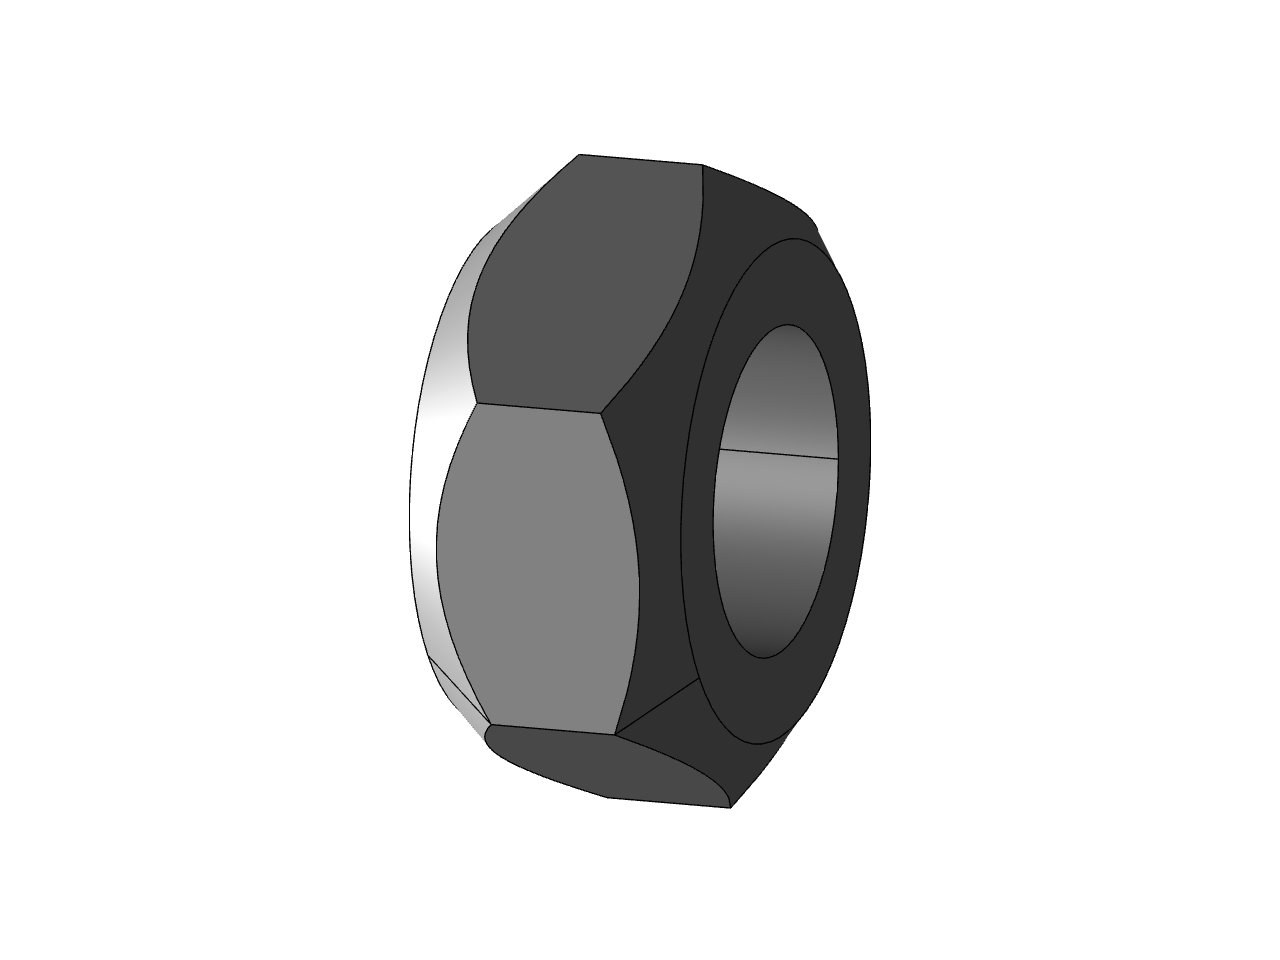
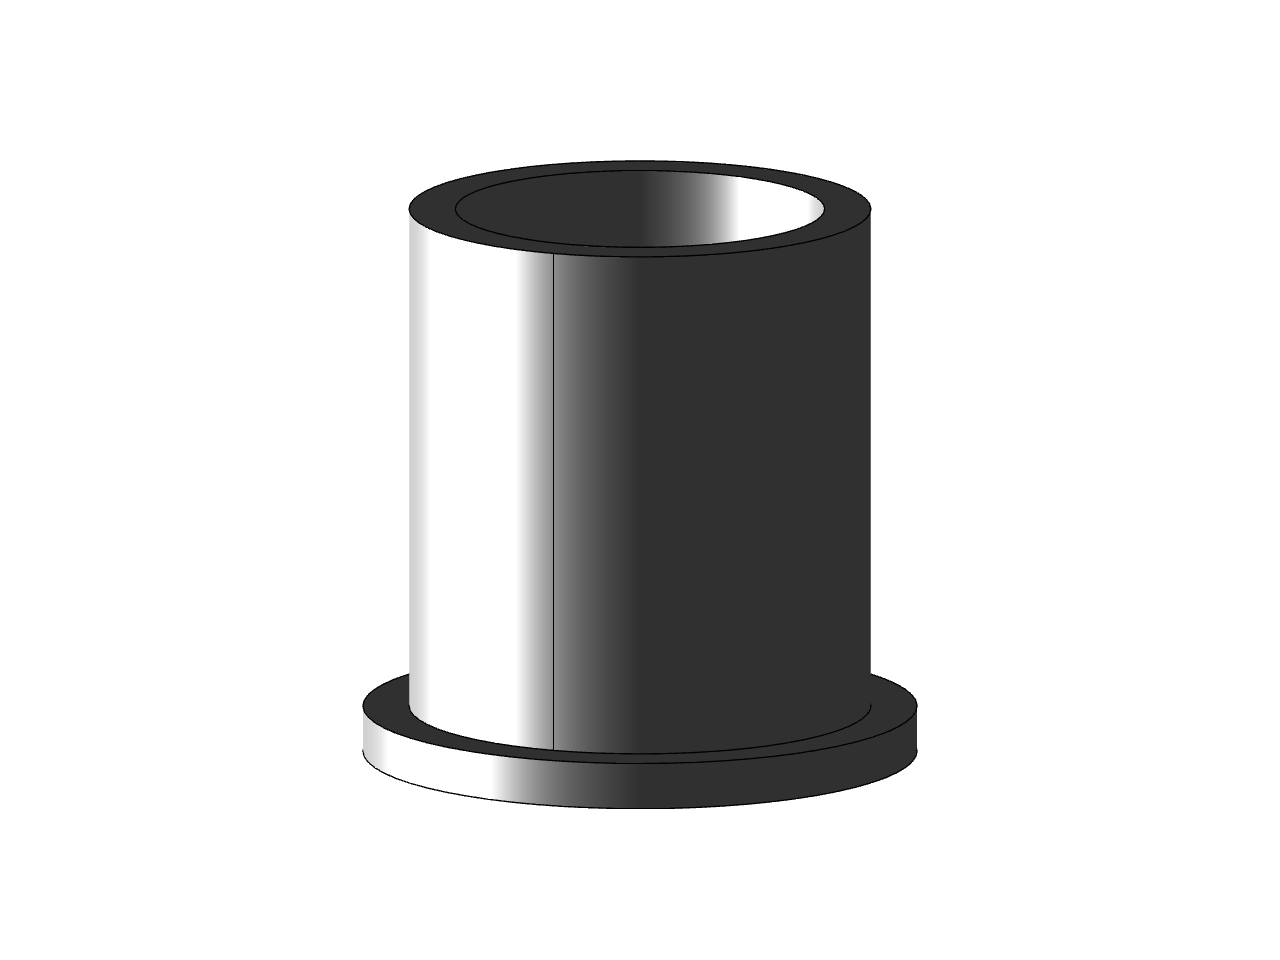
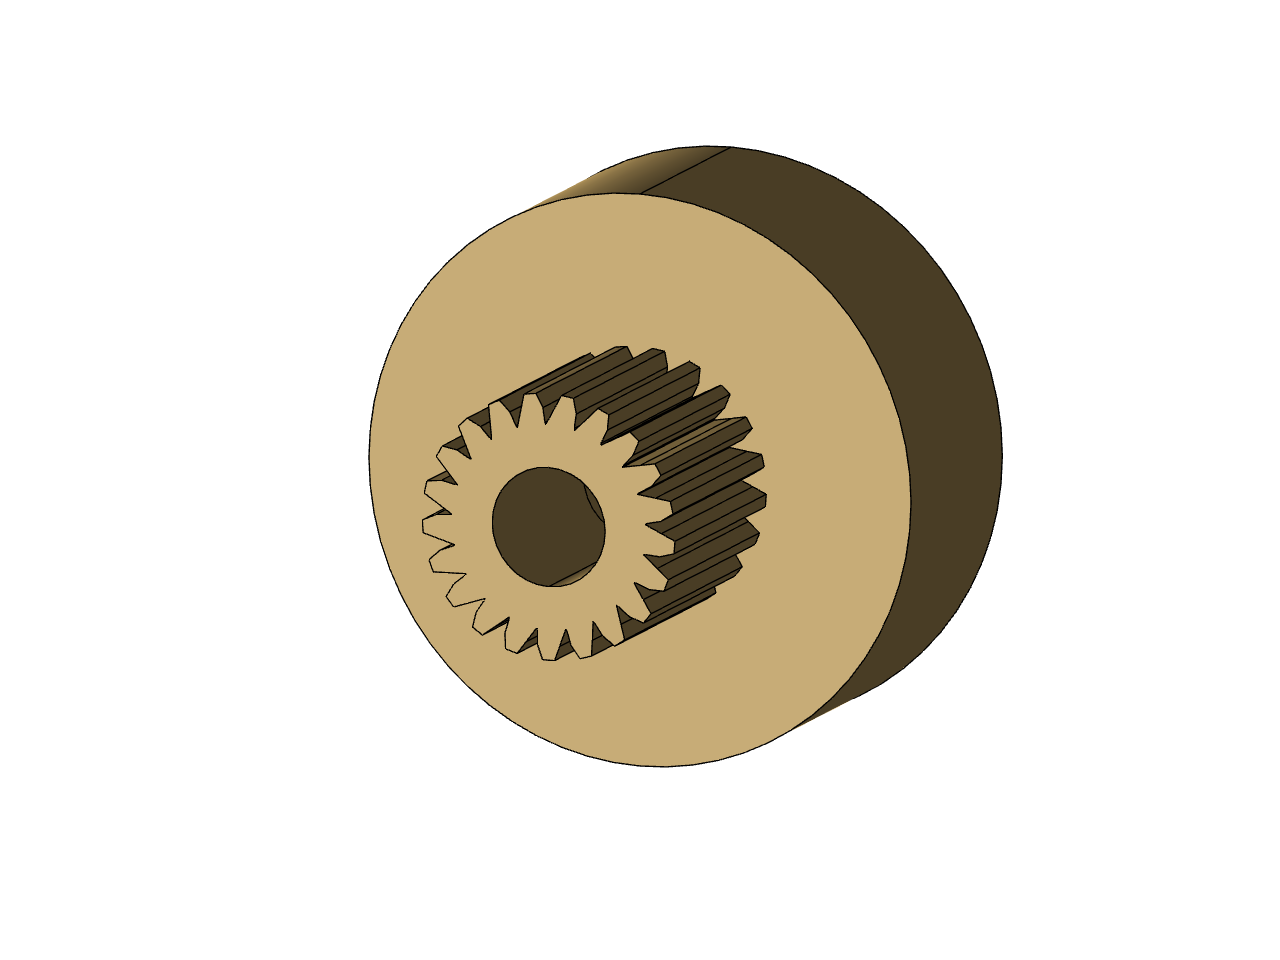
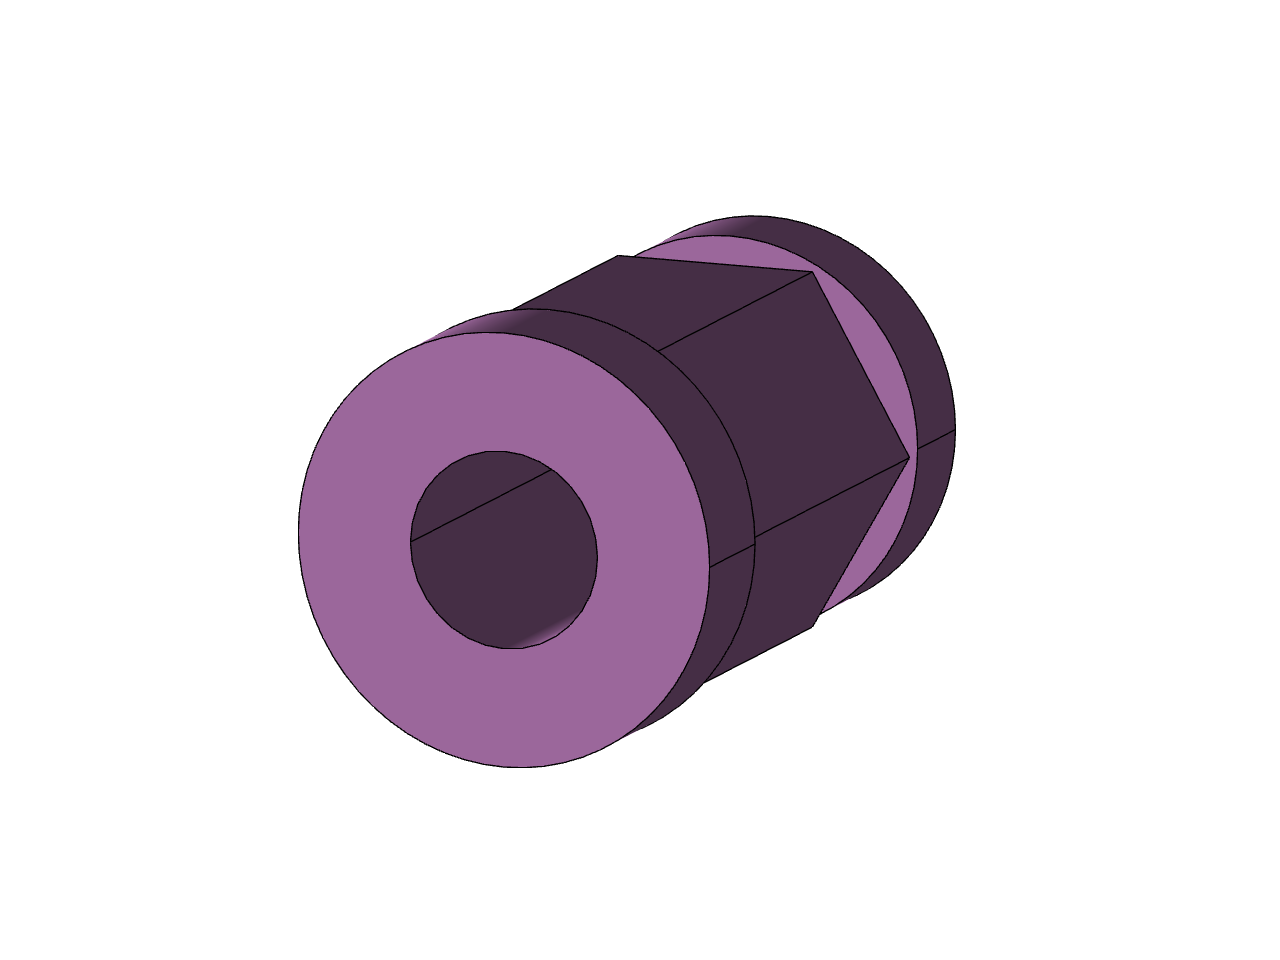
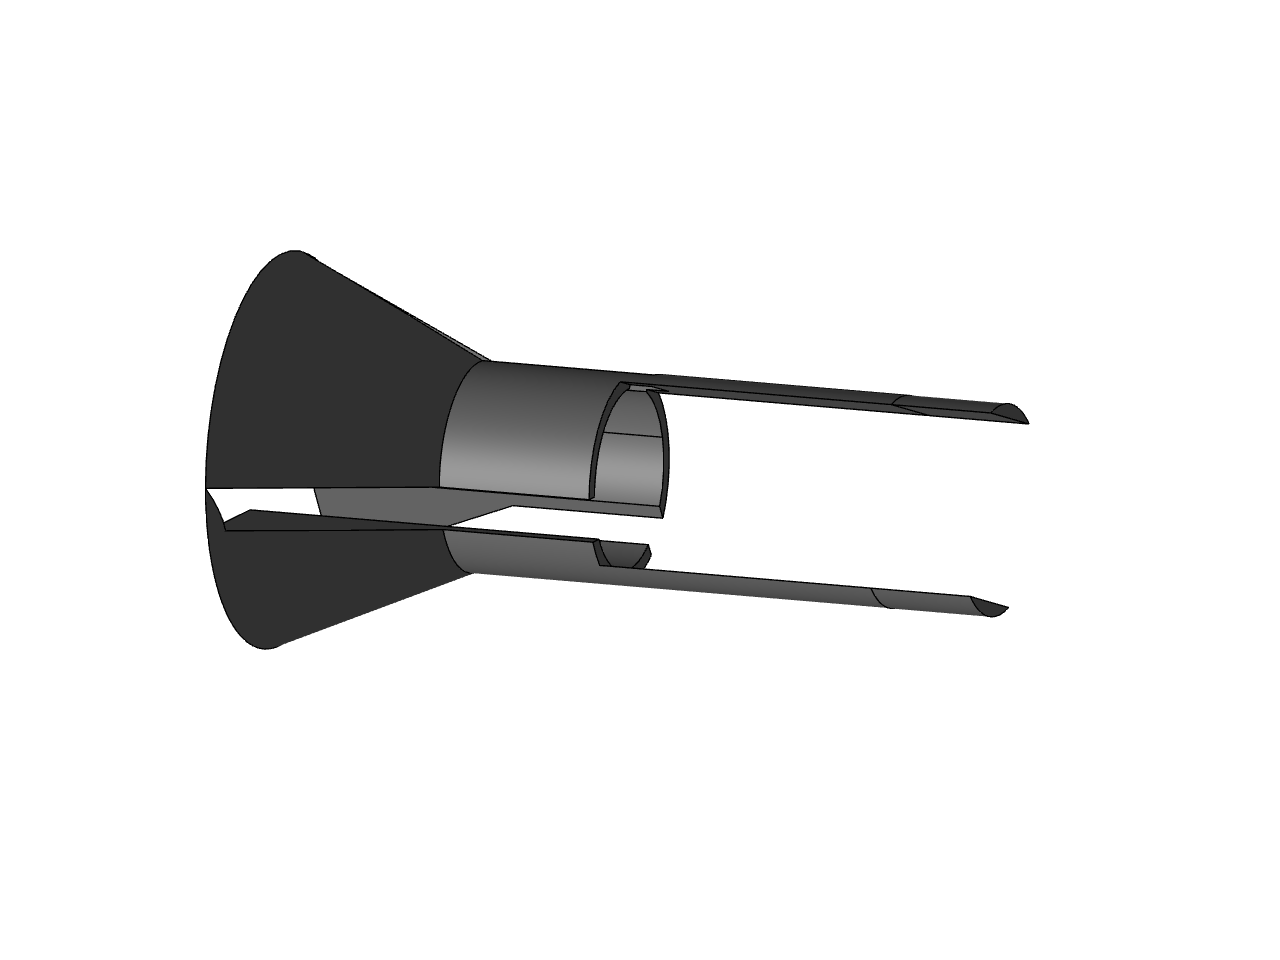

In [11]:
demofile_dir  = pathlib.Path.cwd().parent.joinpath("packages", "cadfiles")    

cadfiles = [
    "nuts_fabwave.x_t",
    "bearings_fabwave.step",
    "gear_fabwave.iges",
    "pn_verschr_r1.prt.1",
    "collets_fabwave.sat"
]

import base64

cells = []
for cadfile in cadfiles:
    prediction, image = cad_detect(demofile_dir / cadfile)
    img_path = Path(image.filename)

    # Read and encode the image as base64
    with open(img_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode("utf-8")
        img_data = f"data:image/png;base64,{encoded}"

    # HTML cell with embedded image and prediction
    cell = f"""
    <td style="text-align:center; padding:10px;">
        <img src="{img_data}" width="200"/><br/>
        <pre style="font-size:12px;">{prediction}</pre>
    </td>
    """
    cells.append(cell)

# Wrap cells in a single table row
html = f"""
<table style="width:100%; table-layout:fixed;">
    <tr>
        {''.join(cells)}
    </tr>
</table>
"""

display(HTML(html))

## Metric Explorer. Review the training data 

In [12]:
from hoops_ai.ml import MetricExplorer

Table of content:
Trend Metrics:
Category Metrics:
Matrix Metrics:


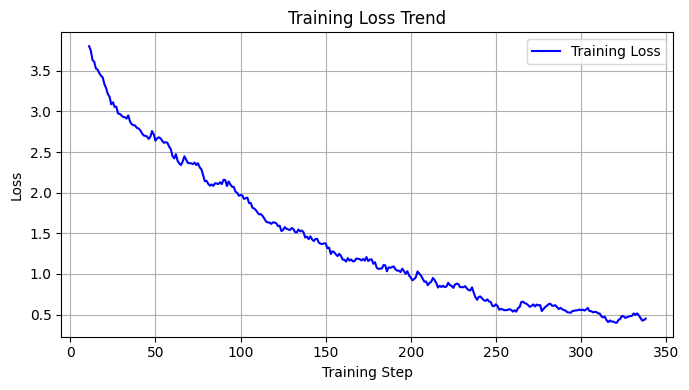

In [13]:
metric_explorer = MetricExplorer(metric_or_flow_file_path=str(flow_root_dir.joinpath("ml.metrics")))
metric_explorer.print_table_of_content()

steps, values = metric_explorer.smooth_trend_metric("train_loss",12)
    
import matplotlib.pyplot as plt


plt.figure(figsize=(7, 4))
plt.plot(steps, values, label='Training Loss', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
metric_explorer.compute_confusion_matrix_stats('confusion_matrix', -1)

{'confusion_matrix accuracy': 0.16769841313362122}

In [15]:
metric_explorer.best_worst_categories('class_accuracy', -1)

{'best': (3, 1.0), 'worst': (0, 0.0)}